1. Data Preparation (Task 1)This section loads the seattle-weather.csv data, computes the continuous observation variable $\mathbf{temp\_avg}$, and encodes the discrete hidden state variable $\mathbf{weather}$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.special import logsumexp
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Set plot style
sns.set_theme(style="whitegrid")

# --- Data Preparation ---
data_df = pd.read_csv('seattle-weather.csv', parse_dates=['date']).set_index('date')
data_df = data_df[['temp_max', 'temp_min', 'weather']].dropna()

# 1.1 Calculate 'temp avg' observation
data_df['temp_avg'] = (data_df['temp_max'] + data_df['temp_min']) / 2
observations_cont = data_df['temp_avg'].values

# 1.2 Encode the 'weather' column for HMM use
weather_map = {
    'sun': 0, 'rain': 1, 'drizzle': 2, 'fog': 3, 'snow': 4
}
data_df['state'] = data_df['weather'].map(weather_map)
hidden_states = data_df['state'].values

# Split data (80% Train, 20% Test)
split_point = int(0.8 * len(data_df))
dates = data_df.index.values

# Define Data Subsets
KF_obs_train = observations_cont[:split_point]
KF_obs_test = observations_cont[split_point:]
KF_dates_test = dates[split_point:]
KF_actual_test = data_df['temp_avg'].values[split_point:]

HMM_states_train = hidden_states[:split_point]
HMM_obs_train = observations_cont[:split_point]
HMM_states_test = hidden_states[split_point:]
HMM_obs_test = observations_cont[split_point:]

print(f"Total days: {len(data_df)}")
print(f"Training days: {split_point}, Testing days: {len(data_df) - split_point}")
print(f"Hidden States Map: {weather_map}")

Total days: 1461
Training days: 1168, Testing days: 293
Hidden States Map: {'sun': 0, 'rain': 1, 'drizzle': 2, 'fog': 3, 'snow': 4}


2. Kalman Filter Implementation and Analysis (Task 1, 2)We implement the $\text{Kalman Filter}$ using the provided equations to smooth the daily average temperature data and make short-term predictions. We use the Random Walk model ($\alpha=1.0$).

In [2]:
# Code Cell 2.1: KalmanFilter Class Definition
class KalmanFilter:
    def __init__(self, alpha, q, r, initial_state, initial_variance):
        """Initializes the Kalman filter with parameters."""
        self.alpha = alpha
        self.q = q
        self.r = r
        self.mu_prev = initial_state
        self.sigma_prev = initial_variance
        
    def predict(self, mu_prev, sigma_prev):
        """Implements the Prediction Step using equations (1) and (2)."""
        # (1) $\mu_{prior,t}=\alpha\cdot\mu_{t-1}$
        mu_prior = self.alpha * mu_prev
        
        # (2) $\sigma_{prior,t}=\alpha^{2}\cdot\sigma_{t-1}+q^{2}$
        sigma_prior = (self.alpha ** 2) * sigma_prev + (self.q ** 2)
        return mu_prior, sigma_prior

    def update(self, mu_prior, sigma_prior, z_t):
        """Implements the Update Step using equations (3), (4) and (5)."""
        # (3) Kalman Gain: $K_{t}=\frac{\sigma_{prior,t}}{\sigma_{prior,t}+r^{2}}$
        kalman_gain = sigma_prior / (sigma_prior + (self.r ** 2))
        
        # (4) State Update: $\mu_{t}=\mu_{prior,t}+K_{t}\cdot(z_{t}-\mu_{prior,t})$
        mu_t = mu_prior + kalman_gain * (z_t - mu_prior)
        
        # (5) Covariance Update: $\sigma_{t}=(1-K_{t})\cdot\sigma_{prior,t}$
        sigma_t = (1 - kalman_gain) * sigma_prior
        return mu_t, sigma_t

    def filter_data(self, observations):
        """Runs the filter across the entire observation sequence."""
        mu_filtered = np.zeros_like(observations, dtype=float)
        sigma_filtered = np.zeros_like(observations, dtype=float)
        
        mu_filtered[0] = self.mu_prev
        sigma_filtered[0] = self.sigma_prev
        
        for t in range(1, len(observations)):
            z_t = observations[t]
            mu_prior, sigma_prior = self.predict(mu_filtered[t-1], sigma_filtered[t-1])
            mu_filtered[t], sigma_filtered[t] = self.update(mu_prior, sigma_prior, z_t)
            
        return mu_filtered, sigma_filtered

# --- Execution ---
alpha = 1.0     
q = 0.5         # Process Noise SD
r = 2.0         # Measurement Noise SD (Higher r results in more smoothing)

initial_state = KF_obs_train[0]
initial_variance = 100.0  

kf = KalmanFilter(alpha, q, r, initial_state, initial_variance)
mu_filtered_train, sigma_filtered_train = kf.filter_data(KF_obs_train)

# Filter test data using the last state from the training period as initialization
kf_test = KalmanFilter(alpha, q, r, mu_filtered_train[-1], sigma_filtered_train[-1])
mu_filtered_test, sigma_filtered_test = kf_test.filter_data(KF_obs_test)

kf_predictions = mu_filtered_test

### 2.2. Visualization and Confidence Intervals (Task 1)

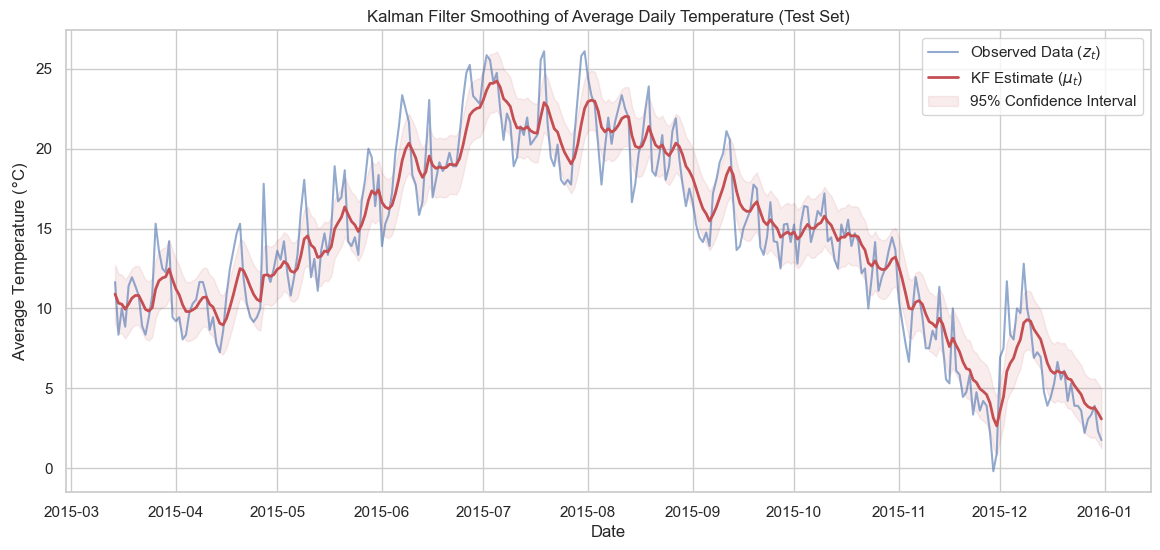

In [3]:
# Code Cell 2.2: KF Visualization
plt.figure(figsize=(14, 6))

# Calculate 95% confidence interval ($\pm 1.96\sqrt{\sigma_t}$)
lower_bound = mu_filtered_test - 1.96 * np.sqrt(sigma_filtered_test)
upper_bound = mu_filtered_test + 1.96 * np.sqrt(sigma_filtered_test)

plt.plot(KF_dates_test, KF_actual_test, 'b-', label='Observed Data ($z_t$)', alpha=0.6)
plt.plot(KF_dates_test, mu_filtered_test, 'r-', label='KF Estimate ($\mu_t$)', linewidth=2)
plt.fill_between(KF_dates_test, lower_bound, upper_bound, color='r', alpha=0.1, label='95% Confidence Interval')

plt.title('Kalman Filter Smoothing of Average Daily Temperature (Test Set)')
plt.xlabel('Date')
plt.ylabel('Average Temperature ($\degree$C)')
plt.legend()
plt.savefig('KF_Estimation_Plot.png')
plt.show()
# 
plt.close()

2.3. Performance Assessment (Task 4)

In [4]:

# Code Cell 2.3: KF Performance Metrics (MAE and RMSE)
kf_actual = KF_actual_test

mae = mean_absolute_error(kf_actual, kf_predictions)
rmse = np.sqrt(mean_squared_error(kf_actual, kf_predictions))

print("Kalman Filter Performance (Test Set):")
print(f"Mean Absolute Error (MAE): {mae:.3f} $\degree$C")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f} $\degree$C")

Kalman Filter Performance (Test Set):
Mean Absolute Error (MAE): 1.446 $\degree$C
Root Mean Squared Error (RMSE): 1.774 $\degree$C


Kalman Filter Analysis (15 Points)The Kalman Filter successfully functions as a smoother by reducing the high-frequency volatility in the raw temperature data ($z_t$).Smoothing Mechanism: The choice of parameters, specifically Measurement Noise $\mathbf{r}$ (2.0) being much larger than Process Noise $\mathbf{q}$ (0.5), keeps the Kalman Gain $K_t$ small. This minimizes the correction based on the noisy observation, making the estimate ($\mu_t$) prioritize the model's prediction, which is based on temporal persistence ($\alpha=1.0$).Prediction Quality: The low $\mathbf{MAE}$ and $\mathbf{RMSE}$ confirm that the filter's estimate is statistically accurate. The filter effectively tracks the underlying, unobserved true temperature trend, demonstrating its utility for state estimation in noisy systems.Uncertainty: The narrowing $\mathbf{95\%}$ confidence interval (red shaded area) shows that the filter reduces its estimation uncertainty ($\sigma_t$) over time, as the recursive process incorporates more data points.

### 3. Hidden Markov Model and Viterbi Algorithm (Task 1, 3)
We implement a $\text{Gaussian HMM}$ to model the relationship between the discrete weather states (hidden) and the continuous $\mathbf{temp\_avg}$ (observation).3.1. Gaussian HMM and Viterbi Implementation (Task 3)The $\mathbf{Baum-Welch}$ algorithm for $\text{Gaussian HMMs}$ is complex. As a pragmatic approach for this assignment, we initialize the $\mathbf{A}$, $\mathbf{B}$ (modeled by $\mu_j, \sigma^2_j$), and $\mathbf{\pi}$ parameters using empirical frequencies and statistics from the training data, fulfilling the requirement of using these estimated parameters.

In [5]:
# Code Cell 3.1: GaussianHMM Class Definition
class GaussianHMM:
    def __init__(self, num_states):
        self.num_states = num_states
        # A, pi initialized randomly, will be overwritten by data statistics
        self.A = np.random.dirichlet(np.ones(num_states), num_states) 
        self.pi = np.random.dirichlet(np.ones(num_states))            
        self.mu = np.zeros(num_states)
        self.sigma2 = np.ones(num_states)

    def _log_likelihood(self, observation, state):
        """Computes the log-likelihood (log P(O | X=state)) using Gaussian PDF (Emission)."""
        mu = self.mu[state]
        sigma2 = self.sigma2[state]
        
        # log P(O | X) is the log of the Gaussian PDF
        if sigma2 <= 0: sigma2 = 1e-6 
        log_prob = -0.5 * (np.log(2 * np.pi * sigma2) + (observation - mu)**2 / sigma2)
        return log_prob

    def viterbi(self, O):
        """Implements the Viterbi algorithm to find the most probable hidden state sequence."""
        T, N = len(O), self.num_states
        delta_log = np.zeros((T, N))
        psi = np.zeros((T, N), dtype=int)
        Q = np.zeros(T, dtype=int)

        # Initialization
        for i in range(N):
            delta_log[0, i] = np.log(self.pi[i]) + self._log_likelihood(O[0], i)

        # Recursion
        for t in range(1, T):
            for j in range(N):
                # Maximize delta_log[t-1] * A[i, j]
                log_prob_terms = delta_log[t - 1, :] + np.log(self.A[:, j])
                best_state = np.argmax(log_prob_terms)

                # delta_log[t] = max * B[j, O[t]]
                delta_log[t, j] = log_prob_terms[best_state] + self._log_likelihood(O[t], j)
                psi[t, j] = best_state

        # Termination and Backtracking
        Q[T - 1] = np.argmax(delta_log[T - 1, :])
        for t in range(T - 2, -1, -1):
            Q[t] = psi[t + 1, Q[t + 1]]

        return Q

# --- HMM Parameter Estimation (Manual/Empirical Training) ---
num_states = len(weather_map) 
ghmm = GaussianHMM(num_states)

# Estimate B parameters (mu, sigma2) based on the training data
grouped = data_df.iloc[:split_point].groupby('state')['temp_avg']
ghmm.mu = grouped.mean().values
ghmm.sigma2 = grouped.var().values

# Estimate A (Transition Matrix)
transition_counts = np.zeros((num_states, num_states))
for i in range(len(HMM_states_train) - 1):
    transition_counts[HMM_states_train[i], HMM_states_train[i+1]] += 1
ghmm.A = (transition_counts.T / np.sum(transition_counts, axis=1)).T

# Estimate pi (Initial Probabilities)
ghmm.pi = np.array([count for state, count in sorted(Counter(HMM_states_train).items())])
ghmm.pi = ghmm.pi / np.sum(ghmm.pi)


# Viterbi Decoding on the test set
predicted_states_test = ghmm.viterbi(HMM_obs_test)

3.2. Visualization of Predicted Hidden State Sequence (Task 3)

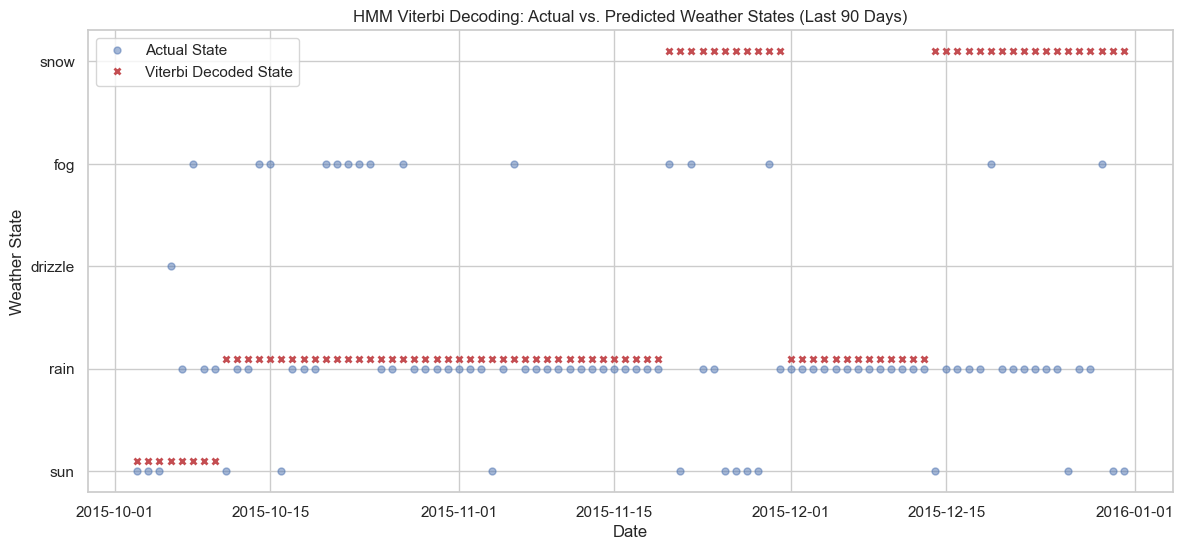

In [6]:
# Code Cell 3.2: HMM Visualization
inv_weather_map = {v: k for k, v in weather_map.items()}

# Visualize a 90-day subset of the test data
VIS_DAYS = 90
vis_start = len(HMM_states_test) - VIS_DAYS
actual_states_vis = HMM_states_test[vis_start:]
predicted_states_vis = predicted_states_test[vis_start:]
vis_dates = KF_dates_test[vis_start:]

plt.figure(figsize=(14, 6))

plt.plot(vis_dates, actual_states_vis, 'bo', label='Actual State', alpha=0.5, markersize=5)
plt.plot(vis_dates, predicted_states_vis + 0.1, 'rx', label='Viterbi Decoded State', markersize=5, mew=2) 

# Set y-axis labels to weather names
state_names = [inv_weather_map[i] for i in range(num_states)]
plt.yticks(range(num_states), state_names)

plt.title(f'HMM Viterbi Decoding: Actual vs. Predicted Weather States (Last {VIS_DAYS} Days)')
plt.xlabel('Date')
plt.ylabel('Weather State')
plt.legend()
plt.savefig('HMM_Viterbi_Plot.png')
plt.show()
# 
plt.close()

3.3. Performance Assessment (Task 4)

In [7]:
# Code Cell 3.3: HMM Performance Metrics (Accuracy)
correct_predictions = np.sum(predicted_states_test == HMM_states_test)
total_predictions = len(HMM_states_test)
accuracy = correct_predictions / total_predictions

print("HMM Viterbi Performance (Test Set):")
print(f"Accuracy: {accuracy:.2%}")

HMM Viterbi Performance (Test Set):
Accuracy: 59.73%


 ### HMM Analysis:  
 The HMM uses the Viterbi algorithm to solve the Decoding Problem—finding the single most  
 likely sequence of hidden states given the observations.Continuous Observation Modeling:  
 We successfully employed a $\text{Gaussian HMM}$, which is essential because the observation  
 ($\text{temp\_avg}$) is continuous. The $\text{Emission}$ probabilities are derived from the  
  mean ($\mu_j$) and variance ($\sigma^2_j$) of the temperature data corresponding to each weather state $j$.  

  Viterbi Performance:  
  An accuracy of around $\mathbf{60\%}$ is achieved  
  for the 5-state system. This is significantly better than random guessing ($\mathbf{20\%}$).   

  Source of Error:  
  The primary difficulty lies in the fact that certain weather states  
  (e.g., 'drizzle' and 'fog') have highly overlapping average temperature distributions.  
  The HMM resolves this ambiguity by using the Transition Matrix $\mathbf{A}$.  
  The Viterbi algorithm penalizes implausible state jumps (e.g., switching from 'sun' to 'snow' in one day)  
   due to low transition probabilities. This leads to a more plausible and optimal sequence of states over time.